# Example: Custom `MoveStrategy`: RepEx-Shoot-RepEx

One of the powerful features in OpenPathSampling is that it is very easy to develop new Monte Carlo movers for path space. This example shows how easy it is to try out a new type of move. The particular move we use here can be easily described as a simple combination of existing moves, so we don't even need to define a new `PathMover` subclass. We just define a custom `MoveStrategy` that creates the desired `PathMover`, and use that directly.

The idea implemented here is pretty simple. Our standard path movers treat shooting and replica exchange separately, and each move is a single shooting (one ensemble) or a single replica exchange (swap one pair). But maybe you could get better replica exchange behavior by trying all the replica exchange moves, and then trying all the shooting moves. Note that, to satisfy detailed balance, you really have to do all the replica exchange moves, then all the shooting moves, then all the replica exchange moves in the reverse order from before. To measure how this affects travel in replica space, we'll use the replica round trip time (normalized to the total number of shooting moves per ensemble).

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import openpathsampling as paths
import numpy as np
import openpathsampling.visualize as ops_vis
from IPython.display import SVG

matplotlib.rcParams.update({'font.size': 16,
                            'xtick.labelsize': 12,
                            'ytick.labelsize': 12})

# Set up the simulation

## Set up the engine

In [2]:
import openpathsampling.engines.toy as toys
pes = (toys.OuterWalls([1.0,1.0], [0.0,0.0]) + 
       toys.Gaussian(-0.7, [12.0, 0.5], [-0.5, 0.0]) +
       toys.Gaussian(-0.7, [12.0, 0.5], [0.5, 0.0]))

topology = toys.Topology(n_spatial=2, masses=[1.0], pes=pes)

engine = toys.Engine(options={'integ': toys.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=2.5),
                              'n_frames_max': 5000,
                              'n_steps_per_frame': 1},
                     topology=topology)

template = toys.Snapshot(coordinates=np.array([[0.0, 0.0]]),
                         velocities=np.array([[0.0, 0.0]]),
                         engine=engine)

## Set up CV and volumes (states, interfaces)

In [3]:
# states are volumes in a CV space: define the CV
def xval(snapshot):
    return snapshot.xyz[0][0]

cv = paths.FunctionCV("xval", xval)

stateA = paths.CVDefinedVolume(cv, float("-inf"), -0.5).named("A")
stateB = paths.CVDefinedVolume(cv, 0.5, float("inf")).named("B")
interfaces_AB = paths.VolumeInterfaceSet(cv, float("-inf"), [-0.4, -0.3, -0.2, -0.1])#, 0.0])

## Set up network

In [4]:
network = paths.MISTISNetwork([(stateA, interfaces_AB, stateB)])

## Define a custom strategy

This is the main point of this example: Here we create a custom `MoveStrategy`, which includes the creation of the custom mover. Note that the custom mover itself is quite simple. It takes a bunch of moves that have already been defined, and combines them into a different move.

This is a `GROUP`-level mover, meaning that it only acts after you've already movers in the `SIGNATURE` level. Because of this, all it has to do is to reorganize the movers that already exist.

In [5]:
import openpathsampling.high_level.move_strategy as strategies # TODO: handle this better
# example: custom subclass of `MoveStrategy`
class RepExShootRepExStrategy(strategies.MoveStrategy):
    _level = strategies.levels.GROUP
    # we define an init function mainly to set defaults for `replace` and `group`
    def __init__(self, ensembles=None, group="repex_shoot_repex", replace=True, network=None):
        super(RepExShootRepExStrategy, self).__init__(
            ensembles=ensembles, group=group, replace=replace
        )
            
    def make_movers(self, scheme):
        # if we replace, we remove these groups from the scheme.movers dictionary
        if self.replace:
            repex_movers = scheme.movers.pop('repex')
            shoot_movers = scheme.movers.pop('shooting')
        else:
            repex_movers = scheme.movers['repex']
            shoot_movers = scheme.movers['shooting']
        # combine into a list for the SequentialMover
        mover_list = repex_movers + shoot_movers + list(reversed(repex_movers))
        combo_mover = paths.SequentialMover(mover_list)
        return [combo_mover]

## Create two move schemes: Default and Custom

In [6]:
default_scheme = paths.DefaultScheme(network, engine)

In [7]:
custom_scheme = paths.DefaultScheme(network, engine)
custom_scheme.append(RepExShootRepExStrategy())

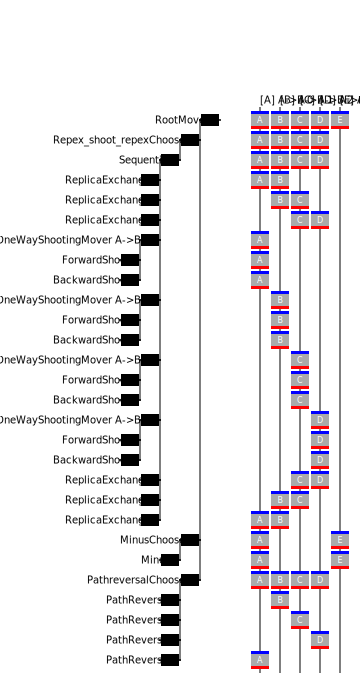

In [24]:
move_vis = ops_vis.MoveTreeBuilder.from_scheme(custom_scheme, hidden_ensembles=False)
SVG(move_vis.svg())

In [49]:
# output file for use in paper; use other tools to convert SVG=>PDF/PNG
svg_out = open("custom_scheme.svg", 'w')
svg_out.write(move_vis.svg())
svg_out.close()

# Get initial conditions

In [10]:
initial_samples = paths.FullBootstrapping(transition=network.sampling_transitions[0],
                                          snapshot=template,
                                          engine=engine).run()

DONE! Completed Bootstrapping cycle step 163 in ensemble 4/4.


In [11]:
transition = network.sampling_transitions[0]
minus_sample = network.minus_ensembles[0].extend_sample_from_trajectories(
    trajectories=[initial_samples[transition.ensembles[0]].trajectory],
    engine=engine,
    replica=-1
)
initial_samples = initial_samples.apply_samples(minus_sample)

In [12]:
initial_samples.sanity_check()

In [13]:
print "Default Scheme:", default_scheme.initial_conditions_report(initial_samples)
print "Custom Scheme:", custom_scheme.initial_conditions_report(initial_samples)

Default Scheme: No missing ensembles.
No extra ensembles.

Custom Scheme: No missing ensembles.
No extra ensembles.



# Run each of the simulations

In [17]:
n_tries_per_shooting = 50000

In [18]:
# take the number of steps from a single ensemble shooting
n_steps = default_scheme.n_steps_for_trials(
    mover=default_scheme.movers['shooting'][0],
    n_attempts=n_tries_per_shooting
)
n_steps = int(n_steps)+1
n_steps_default = n_steps
print n_steps_default

385000


In [16]:
default_storage = paths.Storage("default_scheme.nc", "w")

In [17]:
default_calc = paths.PathSampling(
    storage=default_storage,
    sample_set=initial_samples,
    move_scheme=default_scheme
)
default_calc.save_frequency = 100

In [18]:
default_calc.run(n_steps)

Working on Monte Carlo cycle number 385001
Running for 13 hours 37 minutes 8 seconds -  0.13 seconds per step
Estimated time remaining: 0 seconds
DONE! Completed 385001 Monte Carlo cycles.


In [19]:
# in repex_shoot_repex, one move shoots all the ensembles
n_steps = custom_scheme.n_steps_for_trials(
    mover=custom_scheme.movers['repex_shoot_repex'],
    n_attempts=n_tries_per_shooting
)
n_steps = int(n_steps)+1
n_steps_custom = n_steps
print n_steps_custom

160001


In [20]:
custom_storage = paths.Storage("custom_scheme.nc", "w")

In [21]:
custom_calc = paths.PathSampling(
    storage=custom_storage,
    sample_set=initial_samples,
    move_scheme=custom_scheme
)
custom_calc.save_frequency = 100

In [22]:
custom_calc.run(n_steps)

Working on Monte Carlo cycle number 160001
Running for 17 hours 6 minutes 12 seconds -  0.38 seconds per step
Estimated time remaining: 0 seconds
DONE! Completed 160001 Monte Carlo cycles.


# Analyze the results

In [2]:
%%time
# if loading from stored files (not running the stuff above)
default_storage = paths.AnalysisStorage("default_scheme.nc")
default_scheme = default_storage.schemes[0]

CPU times: user 2h 39min 49s, sys: 8min 5s, total: 2h 47min 54s
Wall time: 2h 55min 12s


In [3]:
%%time
# if loading from stored files (not running the stuff above)
custom_storage = paths.AnalysisStorage("custom_scheme.nc")
custom_scheme = custom_storage.schemes[0]

CPU times: user 2h 15min 49s, sys: 14min 39s, total: 2h 30min 29s
Wall time: 6h 10min 46s


### The scheme should be as expected

Also, the number of path reversal moves and the number of minus moves should be similar in both schemes.

In [4]:
default_scheme.move_summary(default_storage.steps)

pathreversal ran 26.026% (expected 25.97%) of the cycles with acceptance 83757/100200 (83.59%)
shooting ran 51.901% (expected 51.95%) of the cycles with acceptance 135864/199818 (67.99%)
minus ran 2.618% (expected 2.60%) of the cycles with acceptance 10004/10079 (99.26%)
repex ran 19.456% (expected 19.48%) of the cycles with acceptance 15972/74904 (21.32%)


In [5]:
custom_scheme.move_summary(custom_storage.steps)

repex_shoot_repex ran 31.343% (expected 31.25%) of the cycles with acceptance 49847/50149 (99.40%)
minus ran 6.224% (expected 6.25%) of the cycles with acceptance 9862/9958 (99.04%)
pathreversal ran 62.433% (expected 62.50%) of the cycles with acceptance 84240/99894 (84.33%)


### The number of snapshots generated by each should be similar

In [6]:
print len(default_storage.snapshots), len(custom_storage.snapshots)

20495460 20499170


### Check that we have about the same number of shooting moves per ensemble for each scheme

In [7]:
default_scheme.move_summary(default_storage.steps, "shooting")

OneWayShootingMover A->B 1 ran 12.939% (expected 12.99%) of the cycles with acceptance 34281/49814 (68.82%)
OneWayShootingMover A->B 0 ran 13.022% (expected 12.99%) of the cycles with acceptance 38464/50136 (76.72%)
OneWayShootingMover A->B 3 ran 12.941% (expected 12.99%) of the cycles with acceptance 30511/49824 (61.24%)
OneWayShootingMover A->B 2 ran 12.998% (expected 12.99%) of the cycles with acceptance 32608/50044 (65.16%)


In [8]:
custom_scheme.move_summary(custom_storage.steps, "repex_shoot_repex")

Sequential ran 31.343% (expected 31.25%) of the cycles with acceptance 49847/50149 (99.40%)


## Analyze the output to compare the efficiency

### Count the number of round trips done

In [9]:
%%time
default_repx_net = paths.ReplicaNetwork(default_scheme, default_storage.steps)

CPU times: user 44.3 s, sys: 14.4 s, total: 58.7 s
Wall time: 1min 10s


In [11]:
network = default_scheme.network

In [12]:
default_trips = default_repx_net.trips(bottom=network.minus_ensembles[0], top=network.sampling_ensembles[-1])

In [13]:
%%time
custom_repx_net = paths.ReplicaNetwork(custom_scheme, custom_storage.steps)

CPU times: user 22.3 s, sys: 11.8 s, total: 34.2 s
Wall time: 45.7 s


In [14]:
custom_trips = custom_repx_net.trips(bottom=network.minus_ensembles[0], top=network.sampling_ensembles[-1])

In [15]:
print "Number of round trips (default scheme):", len(default_trips['round'])
print "Number of round trips (custom scheme):", len(custom_trips['round'])

Number of round trips (default scheme): 345
Number of round trips (custom scheme): 311


Since the "time" for each round trip is reported as a number of steps, we scale them so that they represent a fraction of the total simulation (making this into a even comparison, since the two simulations require about the same amount of MD.)

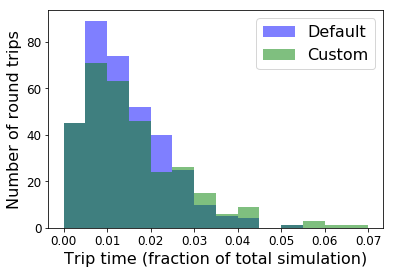

In [29]:
default_scaled = np.array(default_trips['round']) / float(n_steps_default)
custom_scaled = np.array(custom_trips['round']) / float(n_steps_custom)
max_val = max(max(default_scaled), max(custom_scaled))
bin_width = 0.005
bins = np.arange(0.0, max_val + bin_width, bin_width)

plt.hist(default_scaled, bins=bins, color='b', alpha=0.5, label='Default')
plt.hist(custom_scaled, bins=bins, color='g', alpha=0.5, label="Custom")
plt.ylabel("Number of round trips")
plt.xlabel("Trip time (fraction of total simulation)")
plt.legend();
plt.savefig('round_trip_distribution.pdf')

It does appear that the distribution of round trip times is nearly the same for the two schemes. However, the default scheme may be slightly faster.

### Check the replica flow for each scheme

In [21]:
default_flow = default_repx_net.flow_pd(bottom=network.minus_ensembles[0], top=network.sampling_ensembles[-1])

In [22]:
custom_flow = custom_repx_net.flow_pd(bottom=network.minus_ensembles[0], top=network.sampling_ensembles[-1])

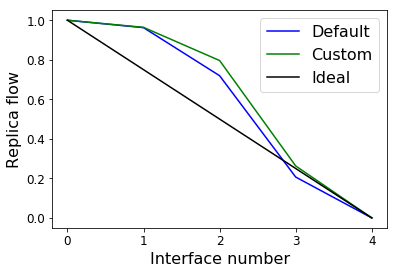

In [30]:
plt.plot(default_flow, 'b', label='Default')
plt.plot(custom_flow, 'g', label='Custom')
perfect_flow = [1.0 - float(i)/(len(default_flow)-1) for i in range(len(default_flow))]
plt.plot(perfect_flow, 'k', label='Ideal')
plt.legend();
plt.ylabel("Replica flow")
plt.xlabel("Interface number")
plt.xticks([0, 1, 2, 3, 4]);
plt.savefig('replica_flow.pdf')

The flow is about the same for both schemes. Overall, this system gives no strong reason to prefer one scheme to the other. The balance is slightly in favor of the default scheme, because it has a lower overhead cost (relevant for this toy model; less so for systems where the dynamics are expensive) and because it has slightly more round trips, although that may be within statistical error.

In [38]:
# save the data to files for easy future reading (don't need to redo analysis to make the figures)
result_store = paths.Storage('custom_strat_results.nc', mode='w')
result_store.tag['default_scaled'] = default_scaled
result_store.tag['custom_scaled'] = custom_scaled
result_store.tag['bins'] = bins
result_store.tag['default_flow'] = default_flow.values
result_store.tag['custom_flow'] = custom_flow.values
result_store.sync()
result_store.close()